## **Bone Fracture Deduction from X-Ray images of MURA dataset**

* MURA is a large image dataset containing the Bone X-ray Images.
* Basically, it is a dataset of musculoskeletal radiographs consisting of 14000+ studies from 11000+ patients, with a total of 40000+ multi-view X-Ray images.
* Each X-Ray image belongs to one of seven standard Upper extremity radiographic study-types, namely; Elbow, Finger, Forearm, Hand, Humerus, Shoulder, and Wrist.

## **Team Members: Abhav Vohra, Priyanka Aiyer, Walter Lizardo**

In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import random

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

#### Download MURA-V1.1 dataset to Colab

> https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

In [2]:
! wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

--2024-05-14 00:31:06--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  15.5MB/s    in 3m 43s  

2024-05-14 00:34:49 (14.5 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]



In [3]:
!ls "/content"

MURA-v1.1.zip  sample_data


###### Unzip the downloaded dataset file in Colab

In [4]:
!unzip -uq "/content/MURA-v1.1.zip" -d "/content/"

In [5]:
!ls "/content/MURA-v1.1/"

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv


#### **Load the Train and Validation X-Ray Image datasets**

In [6]:
data_path = "/content/MURA-v1.1/"

In [7]:
train_path = "/content/MURA-v1.1/train"
os.listdir(train_path)

['XR_HUMERUS',
 'XR_ELBOW',
 'XR_FOREARM',
 'XR_FINGER',
 'XR_HAND',
 'XR_SHOULDER',
 'XR_WRIST']

In [8]:
validation_path = "/content/MURA-v1.1/valid"
os.listdir(validation_path)

['XR_HUMERUS',
 'XR_ELBOW',
 'XR_FOREARM',
 'XR_FINGER',
 'XR_HAND',
 'XR_SHOULDER',
 'XR_WRIST']

In [9]:
df_train_images = pd.read_csv("/content/MURA-v1.1/train_image_paths.csv",dtype=str,header=None)

df_train_images.columns = ['image_path']
df_train_images['label'] = df_train_images['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_train_images['category']  = df_train_images['image_path'].apply(lambda x: x.split('/')[2])
df_train_images['patientId']  = df_train_images['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

df_train_images.head()

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


In [10]:
total_training_images = np.shape(df_train_images)[0]
print("Total training images:", total_training_images )

Total training images: 36808


In [11]:
df_validation_images = pd.read_csv("/content/MURA-v1.1/valid_image_paths.csv",dtype=str,header=None)

df_validation_images.columns = ['image_path']
df_validation_images['label'] = df_validation_images['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_validation_images['category']  = df_validation_images['image_path'].apply(lambda x: x.split('/')[2])
df_validation_images['dir'] =  df_validation_images['image_path'].apply(lambda x: x.split('/')[1])
df_validation_images['patientId']  = df_validation_images['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

df_validation_images.head()

,image_path,label,category,dir,patientId
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186


In [12]:
total_validation_images = np.shape(df_validation_images)[0]
print("Total Validation images:", total_validation_images )

Total Validation images: 3197


### **Data Preprocessing**

In [13]:
df_train_images

,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
...,...,...,...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,negative,XR_HAND,11183
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,negative,XR_HAND,11183
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184


In [14]:
df_train_images['label_index']= df_train_images.category

In [15]:
df_train_images.category.unique()

array(['XR_SHOULDER', 'XR_HUMERUS', 'XR_FINGER', 'XR_ELBOW', 'XR_WRIST',
       'XR_FOREARM', 'XR_HAND'], dtype=object)

In [16]:
df_train_images.label_index.replace('XR_SHOULDER', 6, inplace=True)
df_train_images.label_index.replace('XR_HUMERUS', 5, inplace=True)
df_train_images.label_index.replace('XR_FINGER', 4, inplace=True)
df_train_images.label_index.replace('XR_ELBOW', 3, inplace=True)
df_train_images.label_index.replace('XR_WRIST', 2, inplace=True)
df_train_images.label_index.replace('XR_FOREARM', 1, inplace=True)
df_train_images.label_index.replace('XR_HAND', 0, inplace=True)

In [17]:
df_train_images.head()

,image_path,label,category,patientId,label_index
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001,6
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002,6
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002,6


In [18]:
df_train_images.tail()

,image_path,label,category,patientId,label_index
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,negative,XR_HAND,11183,0
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,negative,XR_HAND,11183,0
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0
36807,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,negative,XR_HAND,11184,0


In [19]:
df_validation_images['label_index']= df_validation_images.category

df_validation_images.label_index.replace('XR_SHOULDER', 6, inplace=True)
df_validation_images.label_index.replace('XR_HUMERUS', 5, inplace=True)
df_validation_images.label_index.replace('XR_FINGER', 4, inplace=True)
df_validation_images.label_index.replace('XR_ELBOW', 3, inplace=True)
df_validation_images.label_index.replace('XR_WRIST', 2, inplace=True)
df_validation_images.label_index.replace('XR_FOREARM', 1, inplace=True)
df_validation_images.label_index.replace('XR_HAND', 0, inplace=True)

df_validation_images.head()

,image_path,label,category,dir,patientId,label_index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive,XR_WRIST,valid,11185,2
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive,XR_WRIST,valid,11186,2


In [20]:
df_validation_images.tail()

,image_path,label,category,dir,patientId,label_index
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,XR_FINGER,valid,11967,4
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...,negative,XR_FINGER,valid,11967,4
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,XR_FINGER,valid,11738,4
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,XR_FINGER,valid,11738,4
3196,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...,negative,XR_FINGER,valid,11738,4


### **Exploratory Data Analysis**

In [21]:
image_count = len(list(pathlib.Path(data_path).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{data_path}>: {image_count}")

Total PNG images found in dir </content/MURA-v1.1/>: 40009


In [22]:
print('Total '+ str(len(df_train_images)) +' train images from all body parts')

Total 36808 train images from all body parts


In [23]:
grouped = df_train_images.groupby(df_train_images.label)

positives = len(grouped.get_group("positive"))
negatives = len(grouped.get_group("negative"))

In [24]:
print("Number of positives:", positives)
print("Number of negatives:", negatives)

Number of positives: 14873
Number of negatives: 21935


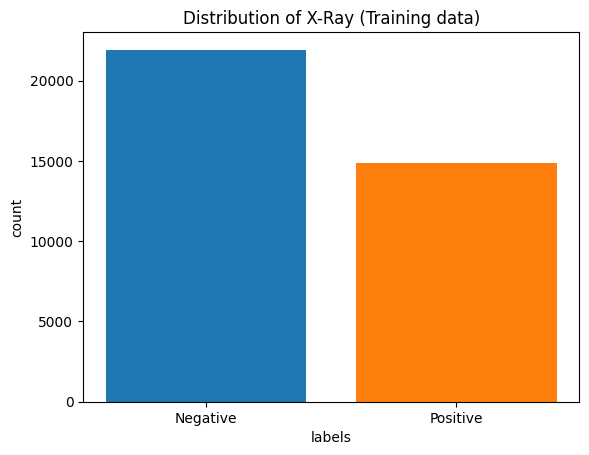

In [25]:
category1 = ["Negative"]
values1     = [negatives]

category2 = ["Positive"]
values2     = [positives]

plt.bar(category1, values1)
plt.bar(category2, values2)
plt.title('Distribution of X-Ray (Training data)')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

#### Validation test data

In [26]:
groupedTest = df_validation_images.groupby(df_validation_images.label)

positivesTest = len(groupedTest.get_group("positive"))
negativesTest = len(groupedTest.get_group("negative"))

In [27]:
print("Number of positives:", positivesTest)
print("Number of negatives:", negativesTest)

Number of positives: 1530
Number of negatives: 1667


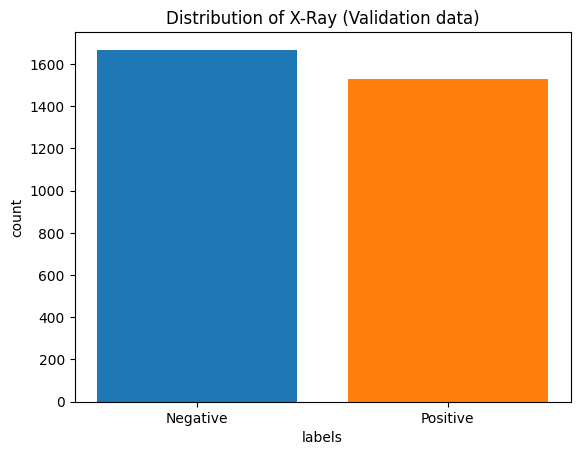

In [28]:
category01 = ["Negative"]
values01     = [negativesTest]

category02 = ["Positive"]
values02     = [positivesTest]

plt.bar(category01, values01)
plt.bar(category02, values02)
plt.title('Distribution of X-Ray (Validation data)')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

##### Plot Graph: Patient count per Study-Type of Bone X-ray category

In [29]:
data_cat= ['train', 'valid']
study_types = list(os.walk('/content/MURA-v1.1/train/'))[0][1] # study types, same for train and valid sets
patients_count = {}  # to store all patients count for each study type, for train and valid sets
for phase in data_cat:
    patients_count[phase] = {}
    for study_type in study_types:
        patients = list(os.walk('/content/MURA-v1.1/%s/%s' %(phase, study_type)))[0][1] # patient folder names
        patients_count[phase][study_type] = len(patients)

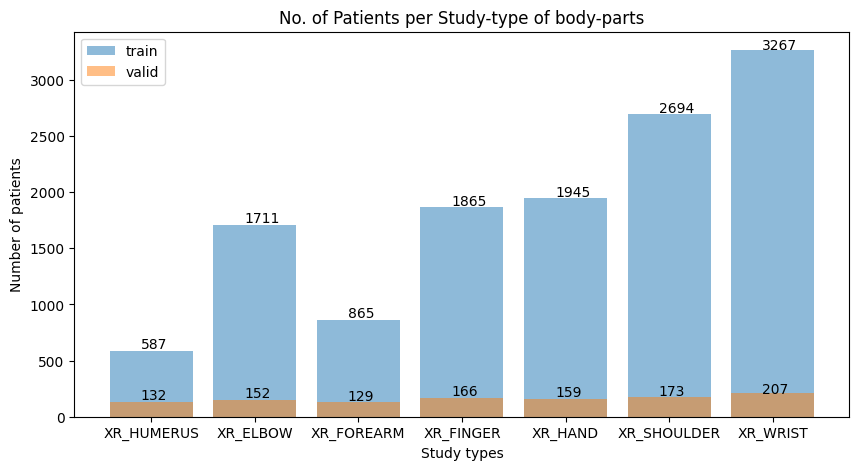

In [30]:
# Plotting the patient counts per study type

fig, ax = plt.subplots(figsize=(10, 5))
for i, phase in enumerate(data_cat):
    counts = patients_count[phase].values()
    m = max(counts)
    for i, v in enumerate(counts):
        if v==m: ax.text(i-0.1, v+3, str(v))
        else: ax.text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    plt.bar(x_pos, counts, alpha=0.5)
    plt.xticks(x_pos, study_types)

plt.title('No. of Patients per Study-type of body-parts')
plt.xlabel('Study types')
plt.ylabel('Number of patients')
plt.legend(['train', 'valid'])
plt.show()

In [31]:
categories_counts = pd.DataFrame(df_train_images['category'].value_counts())

print ('\n\nCategories:\n',categories_counts )
print('\n\nNumber of Patients:',df_train_images['patientId'].nunique())
print('\n\nNumber of Labels:',df_train_images['label'].nunique())
print ('\nPositive X-Ray:',len(df_train_images[df_train_images['label']=='positive']))
print ('\nNegative X-Ray:',len(df_train_images[df_train_images['label']=='negative']))



Categories:
              count
category          
XR_WRIST      9752
XR_SHOULDER   8379
XR_HAND       5543
XR_FINGER     5106
XR_ELBOW      4931
XR_FOREARM    1825
XR_HUMERUS    1272


Number of Patients: 11184


Number of Labels: 2

Positive X-Ray: 14873

Negative X-Ray: 21935


#### **Create the Dense Convolutional Neural Network Model (CNN Architecture)**

In [32]:
!pip install keras-adabound

  Preparing metadata (setup.py) ... done
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6589 sha256=abf19f3ca62bd7dab1bdbe14adfdb34d2d8544143976f2edb8da914529817c30
  Stored in directory: /root/.cache/pip/wheels/c7/0c/82/026bbf0810e0ac6d6b6686fef3891d052534ecb440a0c28c19
Successfully built keras-adabound


In [36]:
from keras.models import Sequential
from sklearn.model_selection import train_test_split

from keras import regularizers, optimizers
from tensorflow import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.losses import categorical_crossentropy

from keras.layers import Input, Conv2D,BatchNormalization
from keras.layers import Activation,SpatialDropout2D,AvgPool2D
from keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D,Flatten,Dropout,Dense

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import Sequential

from keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras.optimizers import SGD, Adam
from keras_adabound import AdaBound

from keras.losses import BinaryCrossentropy

In [37]:
seed = 3352024
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [38]:
train, valid = train_test_split(df_train_images, test_size=0.2, random_state=seed)
train.shape
valid.shape

(7362, 5)

In [39]:
test = df_validation_images.drop(['dir'], axis=1)
test.shape

(3197, 5)

In [40]:
# Image Preprocessing
im_size = 256
image_generator = ImageDataGenerator(rescale=1./255)

train_dataloader = image_generator.flow_from_dataframe(dataframe = train, directory=None,
                                              x_col='image_path', y_col='label',
                                              target_size=(im_size,im_size), class_mode="categorical",
                                              batch_size=16, shuffle=True, seed=seed)

valid_dataloader = image_generator.flow_from_dataframe(dataframe = valid, directory=None,
                                              x_col='image_path', y_col='label',
                                              target_size=(im_size,im_size), class_mode="categorical",
                                              batch_size=16, shuffle=True, seed=seed)

Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.


In [41]:
test_dataloader = image_generator.flow_from_dataframe(dataframe = test, directory=None,
                                              x_col="image_path", y_col="label",
                                              target_size=(im_size,im_size), class_mode="categorical",
                                              batch_size=16, shuffle=True, seed=seed)

Found 3197 validated image filenames belonging to 2 classes.


In [42]:
input_shape = (im_size,im_size,3)
print(input_shape)

(256, 256, 3)


In [43]:
def cnn(input_shape=(im_size, im_size, 3), starting_filters=32,
        conv_layers=1, conv_strides=(1, 1), conv_kernel=(3, 3), convs_per_layer=1,
        batch_norm=False, pooling="max", dropout=None,
        pool_size=(2, 2), pool_strides=(2, 2), last_pooling=None,
        spatial_dropout=None, last_dropout=None):

    inputs = Input(shape=input_shape,name="input")
    x = inputs
    for conv_level in range(conv_layers):
        current_filters = starting_filters * (2 ** conv_level)
        for conv_number in range(convs_per_layer):
            x = Conv2D(filters=current_filters, kernel_size=conv_kernel,
                strides=conv_strides, name=f"conv_{conv_level}_{conv_number}",
                padding='same')(x)

            if batch_norm:
                x = BatchNormalization(name=f"bn_{conv_level}_{conv_number}")(x)

            x = Activation("relu", name=f"conv_{conv_level}_{conv_number}_relu")(x)

        if spatial_dropout:
            x = SpatialDropout2D(spatial_dropout, name=f"sp_dropout_{conv_level}")(x)

        if pooling == 'avg':
            x = AvgPool2D(pool_size=pool_size, strides=pool_strides,
                          name=f"mp_{conv_level}", padding='same')(x)
        elif pooling == 'max':
            x = MaxPool2D(pool_size=pool_size, strides=pool_strides,
                          name=f"mp_{conv_level}", padding='same')(x)

        if dropout:
            x = Dropout(dropout, name=f"dropout_{conv_level}")(x)

    if last_pooling == "avg":
        x = GlobalAveragePooling2D(name=f"lp_{last_pooling}")(x)
    elif last_pooling == "max":
        x = GlobalMaxPooling2D(name=f"lp_{last_pooling}")(x)

    x = Flatten(name="flatten")(x)

    if last_dropout:
        x = Dropout(last_dropout, name="last_dp")(x)

    output = Dense(2, activation='softmax', name="output")(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [44]:
def plot_history(hs, epochs, metric):
    if metric=='loss':
                label_y = 'Loss'
    else : label_y = 'Accuracy'
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)

    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel(label_y)
    plt.legend()
    plt.show()

In [53]:
def display_output(model_name,epochs,hs,model_eval):
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(model_eval[0]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(model_eval[1]))
    print("---")

    # Plot train and validation error per epoch.
    plot_history(hs={model_name: hs}, epochs=epochs, metric='loss')
    plot_history(hs={model_name: hs}, epochs=epochs, metric='accuracy')

**Train the CNN Model**

In [46]:
epochs = 20

In [47]:
cnn_model = cnn(starting_filters=32, conv_layers=4, convs_per_layer=1, pooling='max')

In [48]:
cnn_model.compile(optimizer=Adam(), loss= categorical_crossentropy, metrics=["accuracy"])

In [49]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)

hs = cnn_model.fit(train_dataloader, validation_data = valid_dataloader, epochs = epochs, callbacks=[early_stop] )

print('Finished training.')

Epoch 1/20
1841/1841 [==============================] - 225s 118ms/step - loss: 0.6657 - accuracy: 0.5970 - val_loss: 0.6610 - val_accuracy: 0.5929
Epoch 2/20
1841/1841 [==============================] - 195s 106ms/step - loss: 0.6541 - accuracy: 0.6078 - val_loss: 0.6533 - val_accuracy: 0.6059
Epoch 3/20
1841/1841 [==============================] - 191s 104ms/step - loss: 0.6449 - accuracy: 0.6183 - val_loss: 0.6507 - val_accuracy: 0.6145
Epoch 4/20
1841/1841 [==============================] - 193s 105ms/step - loss: 0.6329 - accuracy: 0.6325 - val_loss: 0.6497 - val_accuracy: 0.6108
Epoch 5/20
1841/1841 [==============================] - 193s 105ms/step - loss: 0.6132 - accuracy: 0.6513 - val_loss: 0.6510 - val_accuracy: 0.6285
Epoch 6/20
1841/1841 [==============================] - 192s 104ms/step - loss: 0.5905 - accuracy: 0.6748 - val_loss: 0.6603 - val_accuracy: 0.6106
Epoch 7/20
1841/1841 [==============================] - 191s 104ms/step - loss: 0.5649 - accuracy: 0.7002 - val_

In [50]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_0_0 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 conv_0_0_relu (Activation)  (None, 256, 256, 32)      0         
                                                                 
 mp_0 (MaxPooling2D)         (None, 128, 128, 32)      0         
                                                                 
 conv_1_0 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv_1_0_relu (Activation)  (None, 128, 128, 64)      0         
                                                                 
 mp_1 (MaxPooling2D)         (None, 64, 64, 64)        0     

* Evaluate the CNN Model

In [51]:
# Model Evaluation
cnn_model_eval = cnn_model.evaluate(test_dataloader)

200/200 [==============================] - 17s 83ms/step - loss: 0.6738 - accuracy: 0.5868


##### Observation:
* Training Accuracy is observed to be ~**85%**
* Validation Accuracy is observed to be ~**65%**

Train Loss     : 0.32391
Validation Loss: 1.07913
Test Loss      : 0.67383
---
Train Accuracy     : 0.85186
Validation Accuracy: 0.64466
Test Accuracy      : 0.58680
---


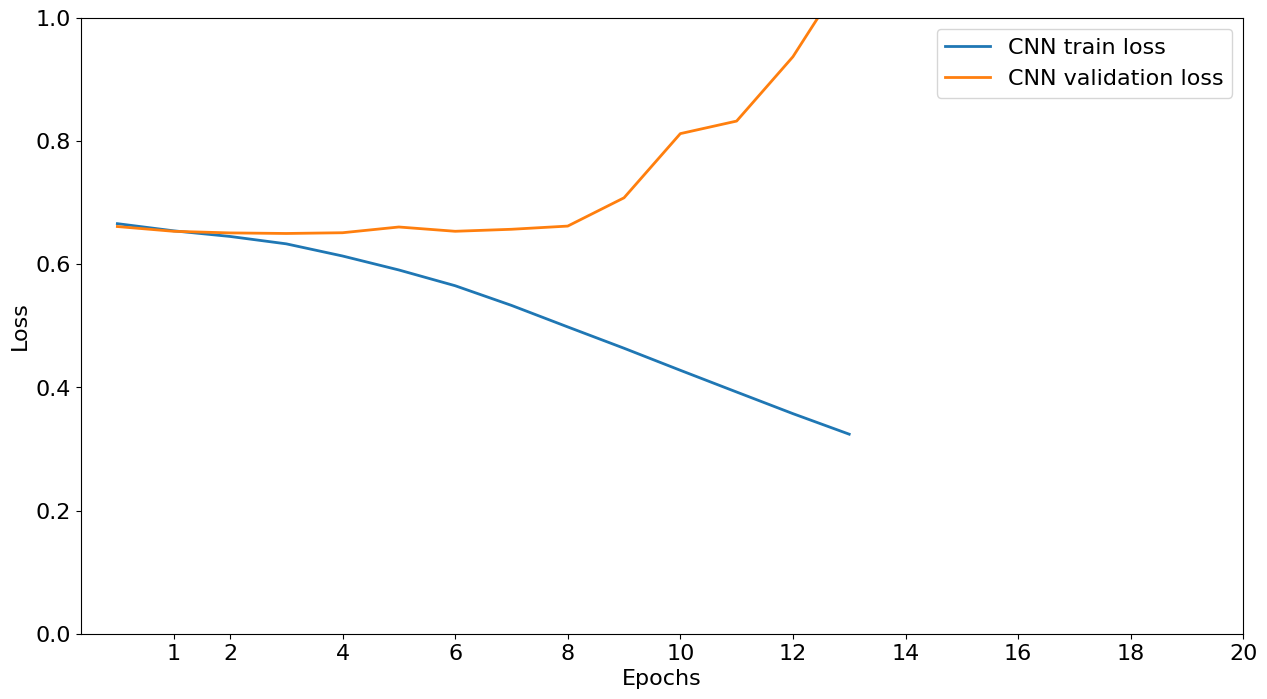

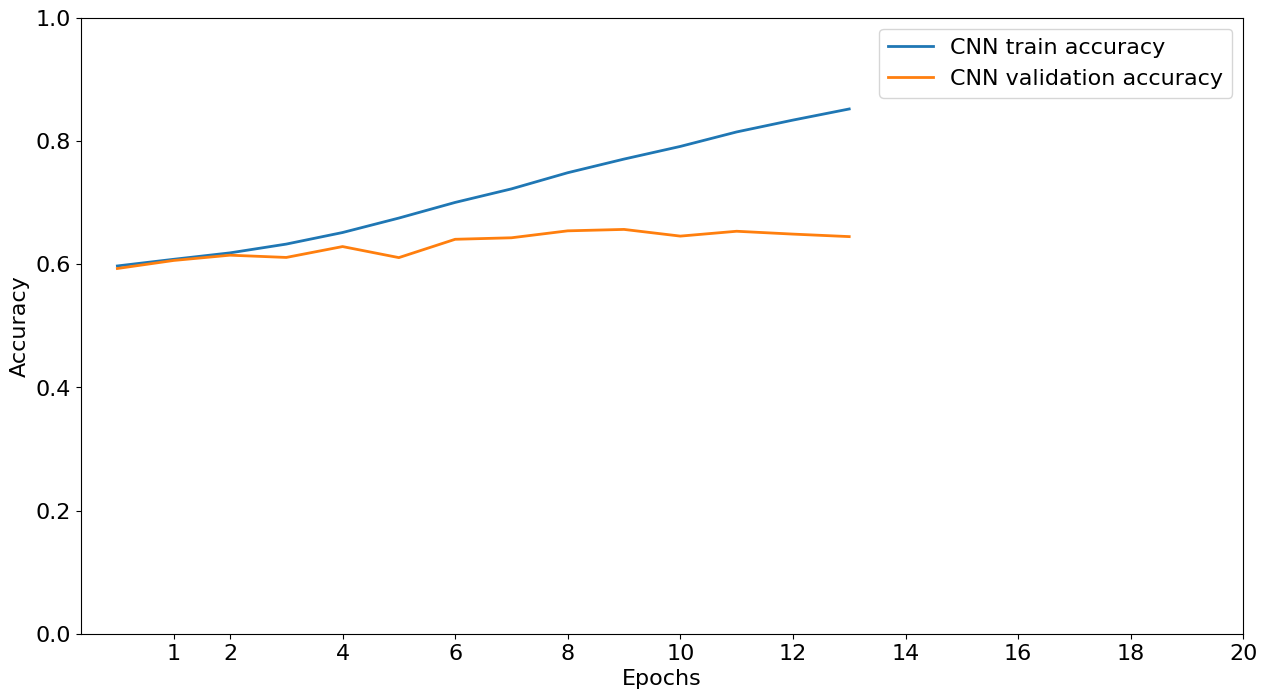

In [54]:
display_output(model_name='CNN',epochs= epochs,hs = hs,model_eval = cnn_model_eval)

References:
* https://www.mdpi.com/2079-7737/11/5/665
* https://www.mdpi.com/1424-8220/21/16/5381